# Modelling
Based on our analysis, we have determined that et don't make sense to use linear og polynomial regression on our data.

Instead we have chosen other models which we have knowledge of, and this includes Descission Tree,  Random Forrest Classifier and Nayve Bayes. Therefore we need to add some classification values to our data, as these models are used to predict nominel data.

We will try predict if the market goes up or down in the next month with these three models. We hope that we with some certancy can determine the movement, but know that there are a lot of other factors that affects the market.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, train_test_split
import joblib

pd.set_option("display.max_columns", None)
#pd.set_option("display.max_rows", None)

In [2]:
# Data between 1987-2017 - monthly
df = pd.read_csv('https://raw.githubusercontent.com/badranyoussef/bi-exam-project-stock/refs/heads/main/datasets/monthly_combined_data.csv')

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Date                               362 non-null    datetime64[ns]
 1   Open SP500                         362 non-null    float64       
 2   High SP500                         362 non-null    float64       
 3   Low SP500                          362 non-null    float64       
 4   Close SP500                        362 non-null    float64       
 5   Volume SP500                       362 non-null    float64       
 6   Interest Rate                      362 non-null    float64       
 7   Unemployment Rate                  362 non-null    float64       
 8   Inflation Rate                     362 non-null    float64       
 9   CPIAUCSL                           362 non-null    float64       
 10  Open RUSSELL2000                   362

In [4]:
df.columns

Index(['Date', 'Open SP500', 'High SP500', 'Low SP500', 'Close SP500',
       'Volume SP500', 'Interest Rate', 'Unemployment Rate', 'Inflation Rate',
       'CPIAUCSL', 'Open RUSSELL2000', 'High RUSSELL2000', 'Low RUSSELL2000',
       'Close RUSSELL2000', 'Volume RUSSELL2000', 'Close Oil', 'Close Gold',
       'Open Gold', 'High Gold', 'Low Gold', 'Change % Gold',
       'OPEN_CLOSE_CHANGE_ABB_SP500', 'OPEN_CLOSE_CHANGE_ABB_RUSSELL2000',
       'OPEN_CLOSE_CHANGE_ABB_Gold', 'Interest_Rate_Change',
       'Inflation_Rate_Change', 'Unemployment_Rate_Change', 'CPI_Change'],
      dtype='object')

In [5]:
columns_to_flag = [
     'OPEN_CLOSE_CHANGE_ABB_SP500',
     'OPEN_CLOSE_CHANGE_ABB_RUSSELL2000'
]

for col in columns_to_flag:
    df[f'{col}_Flagged'] = (df[col] > 0).astype(int)

In [6]:
df['Flag_Next_Month_SP500'] = df['OPEN_CLOSE_CHANGE_ABB_SP500_Flagged'].shift(-1)
df['Flag_Next_Month_RUSSELL2000'] = df['OPEN_CLOSE_CHANGE_ABB_RUSSELL2000_Flagged'].shift(-1)
df

,Date,Open SP500,High SP500,Low SP500,Close SP500,Volume SP500,Interest Rate,Unemployment Rate,Inflation Rate,CPIAUCSL,Open RUSSELL2000,High RUSSELL2000,Low RUSSELL2000,Close RUSSELL2000,Volume RUSSELL2000,Close Oil,Close Gold,Open Gold,High Gold,Low Gold,Change % Gold,OPEN_CLOSE_CHANGE_ABB_SP500,OPEN_CLOSE_CHANGE_ABB_RUSSELL2000,OPEN_CLOSE_CHANGE_ABB_Gold,Interest_Rate_Change,Inflation_Rate_Change,Unemployment_Rate_Change,CPI_Change,OPEN_CLOSE_CHANGE_ABB_SP500_Flagged,OPEN_CLOSE_CHANGE_ABB_RUSSELL2000_Flagged,Flag_Next_Month_SP500,Flag_Next_Month_RUSSELL2000
0,1987-11-30,244.770004,257.209991,225.750000,230.300003,3.892930e+09,6.69,5.8,4.4,115.400,110.790001,122.050003,107.900002,111.699997,3.892920e+09,17.70,490.46,469.10,490.46,457.14,1.23,-14.419954,0.929994,-51.78,-0.60,0.1,-0.2,0.400,0,1,1.0,1.0
1,1987-12-31,230.320007,253.350006,221.240005,247.080002,3.926750e+09,6.77,5.7,4.2,115.600,111.690002,121.589996,106.160004,120.419998,3.926750e+09,17.60,485.85,492.67,498.25,479.47,0.70,16.649993,8.750015,-70.46,0.08,-0.2,-0.1,0.200,1,1,1.0,1.0
2,1988-01-31,247.839996,261.779999,240.169998,257.070007,3.664840e+09,6.83,5.7,4.3,116.000,119.500000,128.190002,118.610001,125.239998,3.664840e+09,16.28,454.01,487.45,487.06,454.01,-2.69,9.150053,5.750007,-72.26,0.06,0.1,0.0,0.400,1,1,1.0,1.0
3,1988-02-29,257.049988,267.820007,247.820007,267.820007,3.693240e+09,6.58,5.7,4.3,116.200,125.239998,137.690002,124.940002,136.100006,3.693240e+09,14.73,430.23,455.80,454.63,429.45,0.18,11.189988,10.829993,-70.33,-0.25,0.0,0.0,0.200,1,1,0.0,1.0
4,1988-03-31,267.820007,272.640015,256.070007,258.890015,4.052970e+09,6.58,5.7,4.4,116.500,136.100006,143.380005,136.070007,142.149994,4.052970e+09,15.65,453.85,431.55,456.74,427.66,-0.63,-8.829986,6.000001,-48.16,0.00,0.1,0.0,0.300,0,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,2017-08-31,2477.100098,2490.870117,2417.350098,2471.649902,7.061603e+10,1.07,4.7,2.2,245.183,1426.030029,1430.660034,1349.349976,1405.280029,7.061603e+10,52.69,1322.07,1268.80,1326.14,1251.41,1.02,-12.118655,-19.870245,44.48,0.00,0.0,0.0,1.020,0,0,1.0,1.0
358,2017-09-30,2474.419922,2519.439941,2446.550049,2519.360107,6.633798e+10,1.06,4.7,2.2,246.435,1405.819946,1493.560059,1393.880005,1490.859985,6.633798e+10,57.02,1279.45,1321.80,1357.94,1277.64,-0.61,30.170895,83.840209,-43.04,-0.01,0.0,0.0,1.252,1,1,1.0,1.0
359,2017-10-31,2521.199951,2582.979980,2520.399902,2575.260010,7.087157e+10,1.07,4.7,2.2,246.435,1491.050049,1514.939941,1482.530029,1502.530029,7.087157e+10,61.35,1271.58,1279.50,1306.80,1260.89,-0.37,26.179931,8.090335,-6.61,0.01,0.0,0.0,0.000,1,1,1.0,1.0
360,2017-11-30,2583.209961,2657.739990,2557.449951,2647.580078,7.317326e+10,1.07,4.7,2.2,247.284,1504.540039,1551.689941,1454.170044,1544.140015,7.317326e+10,63.53,1274.76,1270.88,1299.20,1265.55,-0.69,69.291017,41.080205,4.46,0.00,0.0,0.0,0.849,1,1,0.0,0.0


In [7]:
df = df.dropna()

# ML with DecisionTreeClassification

In [8]:
df.columns

Index(['Date', 'Open SP500', 'High SP500', 'Low SP500', 'Close SP500',
       'Volume SP500', 'Interest Rate', 'Unemployment Rate', 'Inflation Rate',
       'CPIAUCSL', 'Open RUSSELL2000', 'High RUSSELL2000', 'Low RUSSELL2000',
       'Close RUSSELL2000', 'Volume RUSSELL2000', 'Close Oil', 'Close Gold',
       'Open Gold', 'High Gold', 'Low Gold', 'Change % Gold',
       'OPEN_CLOSE_CHANGE_ABB_SP500', 'OPEN_CLOSE_CHANGE_ABB_RUSSELL2000',
       'OPEN_CLOSE_CHANGE_ABB_Gold', 'Interest_Rate_Change',
       'Inflation_Rate_Change', 'Unemployment_Rate_Change', 'CPI_Change',
       'OPEN_CLOSE_CHANGE_ABB_SP500_Flagged',
       'OPEN_CLOSE_CHANGE_ABB_RUSSELL2000_Flagged', 'Flag_Next_Month_SP500',
       'Flag_Next_Month_RUSSELL2000'],
      dtype='object')

In [9]:
columns_to_drop_sp500 = ['Date',
       'Open SP500', 'High SP500', 'Low SP500', 'Close SP500', 'Volume SP500',
       #'Interest Rate', 'Unemployment Rate', #'Inflation Rate', 'CPIAUCSL',
       'Open RUSSELL2000', 'High RUSSELL2000', 'Low RUSSELL2000', 'Volume RUSSELL2000', 'Close RUSSELL2000',
       'Close Oil', 'Close Gold', 'Open Gold', 'High Gold', 'Low Gold', 'Change % Gold',
       'OPEN_CLOSE_CHANGE_ABB_SP500', 'OPEN_CLOSE_CHANGE_ABB_RUSSELL2000',
       'OPEN_CLOSE_CHANGE_ABB_Gold',
       'Interest_Rate_Change', 'Inflation_Rate_Change', 'Unemployment_Rate_Change', 'CPI_Change',
       'OPEN_CLOSE_CHANGE_ABB_RUSSELL2000_Flagged', #'OPEN_CLOSE_CHANGE_ABB_SP500_Flagged',
       'Flag_Next_Month_SP500',
       'Flag_Next_Month_RUSSELL2000'
    ]

columns_to_drop_russell2000 = ['Date',
       'Open SP500', 'High SP500', 'Low SP500', 'Close SP500', 'Volume SP500',
       #'Interest Rate', 'Unemployment Rate', #'Inflation Rate', 'CPIAUCSL',
       'Open RUSSELL2000', 'High RUSSELL2000', 'Low RUSSELL2000', 'Close RUSSELL2000', #'Volume RUSSELL2000',
       'Close Oil', 'Close Gold', 'Open Gold', 'High Gold', 'Low Gold', 'Change % Gold',
       'OPEN_CLOSE_CHANGE_ABB_SP500', 'OPEN_CLOSE_CHANGE_ABB_RUSSELL2000',
       'OPEN_CLOSE_CHANGE_ABB_Gold',
       'Interest_Rate_Change', 'Inflation_Rate_Change', 'Unemployment_Rate_Change', 'CPI_Change',
       'OPEN_CLOSE_CHANGE_ABB_SP500_Flagged', #'OPEN_CLOSE_CHANGE_ABB_RUSSELL2000_Flagged',
       'Flag_Next_Month_SP500',
       'Flag_Next_Month_RUSSELL2000'
    ]

In [10]:
# Function to train and evaluate model using TimeSeriesSplit
def evaluate_model(model, X, y, max_splits):
    """
    Train and evaluate a machine learning model using TimeSeriesSplit.

    Args:
    - model: A machine learning model instance (e.g., DecisionTreeClassifier, RandomForestClassifier, GaussianNB).
    - X: Feature matrix.
    - y: Target variable.
    - max_splits: Maximum number of splits for TimeSeriesSplit.
    - max_depth: Maximum depth for decision tree-based models (used if applicable).

    Returns:
    - best_n_splits: The best number of splits based on highest accuracy.
    - best_accuracy: The highest average accuracy achieved.
    - model: Trained model using the best n_splits.
    """

    # Initialize variables to store results
    best_n_splits = None
    best_accuracy = 0
    results = {}

    # Test different n_splits values
    for n_splits in range(2, max_splits):  # Testing from 2 to max_splits
        tscv = TimeSeriesSplit(n_splits=n_splits)
        accuracies = []

        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Train the model
            model.fit(X_train, y_train)

            # Predict on test data
            y_pred = model.predict(X_test)

            # Evaluate the model
            accuracy = accuracy_score(y_test, y_pred)
            accuracies.append(accuracy)

        # Calculate the average accuracy for this n_splits
        average_accuracy = np.mean(accuracies)
        results[n_splits] = average_accuracy

        # Update the best n_splits if the current one is better
        if average_accuracy > best_accuracy:
            best_accuracy = average_accuracy
            best_n_splits = n_splits

    return best_n_splits, best_accuracy

Best n_splits: 3 with Average Accuracy: 0.56
[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
tests result of y_pred vs x test. Final Accuracy on last fold with best n_splits: 0.53


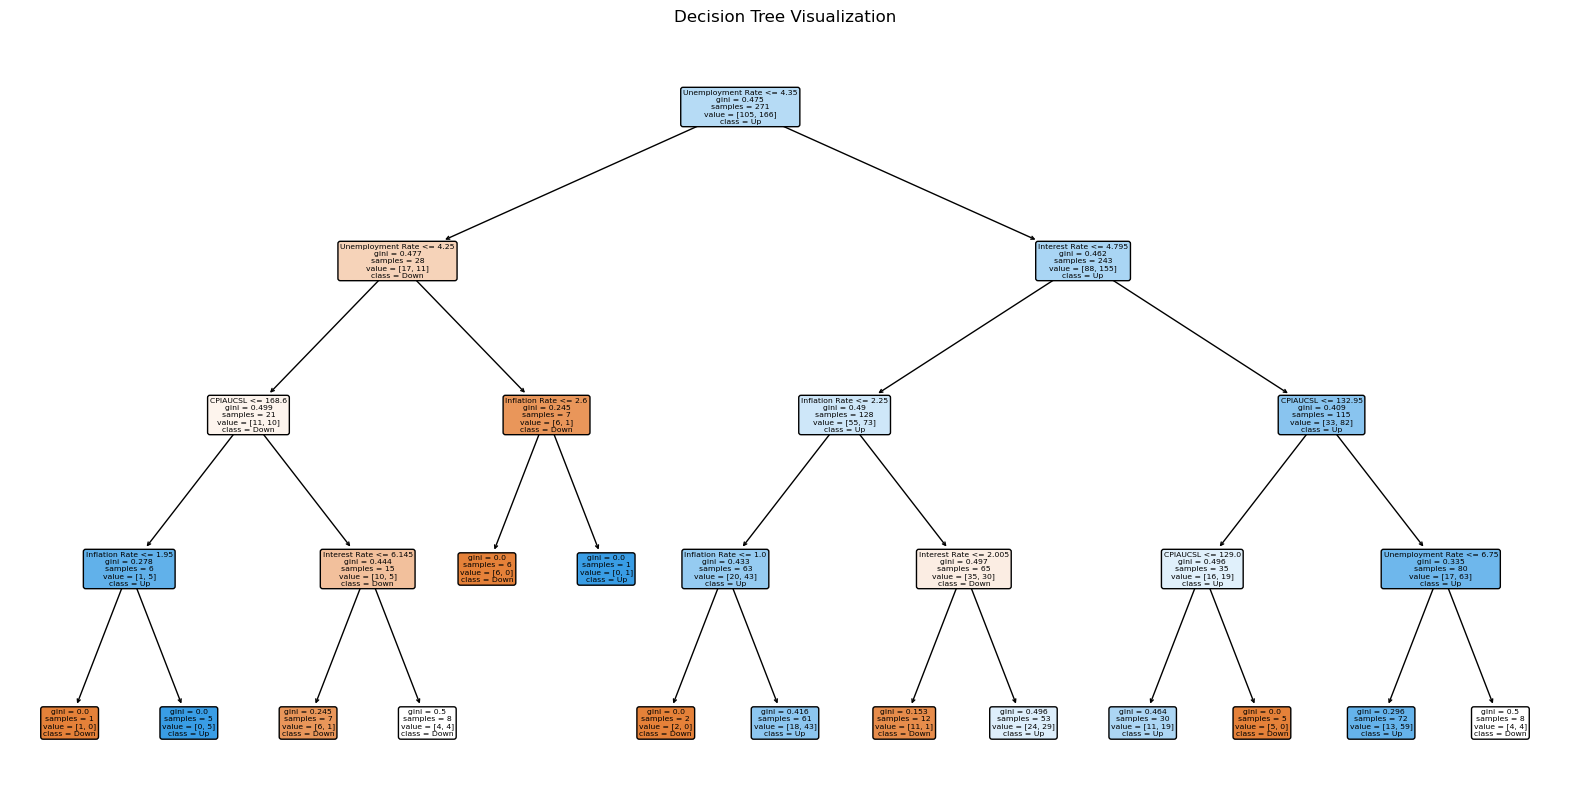

In [11]:
# Model

max_splits = 20
dt_model = DecisionTreeClassifier(max_depth=4, random_state=42)
# Fjern irrelevante kolonner og angiv den afhængige variabel
X = df.drop(columns=columns_to_drop_sp500)
y = df['Flag_Next_Month_SP500']

best_n_splits, best_accuracy = evaluate_model(dt_model, X, y, max_splits)

# Udskriv resultaterne
print(f"Best n_splits: {best_n_splits} with Average Accuracy: {best_accuracy:.2f}")

# Endelig træning med den bedste n_splits
tscv = TimeSeriesSplit(n_splits=best_n_splits)
#model_dt = DecisionTreeClassifier(max_depth=depth_max, random_state=42)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Træn modellen
    dt_model.fit(X_train, y_train)
    
    # Forudsige på testdata
    y_pred = dt_model.predict(X_test)

print(y_pred)
# Udfør den endelige evaluering
accuracy = accuracy_score(y_test, y_pred)
print(f"tests result of y_pred vs x test. Final Accuracy on last fold with best n_splits: {accuracy:.2f}")

# Visualisér Decision Tree
plt.figure(figsize=(20,10))
plot_tree(dt_model, feature_names=X.columns, class_names=['Down', 'Up'], filled=True, rounded=True)
plt.title('Decision Tree Visualization')
plt.show()

In [12]:
#joblib.dump(dt_model, '../models/dt_model_sp500.pkl')
#joblib.dump(dt_model, '../models/dt_model_russell2000.pkl')

#### Now testing the model with the X_test to see the performance

Confusion Matrix:
[[ 4 30]
 [12 44]]


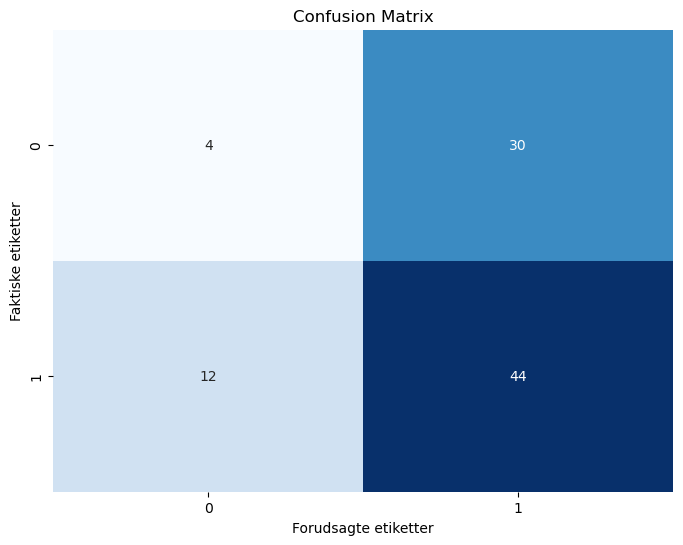

In [13]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Visualisering af Confusion Matrix som heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Forudsagte etiketter")
plt.ylabel("Faktiske etiketter")
plt.show()


## RandomForrestClassifier

In [14]:
# Initialiser Random Forest Classifier
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

best_n_splits_rfc, best_accuracy_rfc = evaluate_model(model_rf, X, y, max_splits)

#print(f'Average Accuracy with {n_splits} splits: {avg_accuracy:.2f}')
#best_n_splits = split_values[np.argmax(avg_accuracies)]
#print(f'\nBest number of splits: {best_n_splits}')

# Definer cross-validation med det fundne bedste antal splits
best_tscv_rfc = TimeSeriesSplit(n_splits=best_n_splits_rfc)

# Træn modellen med det fundne bedste antal splits og evaluer
for train_index, test_index in best_tscv_rfc.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]  # Brug iloc til positionel indeksering
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Brug iloc til positionel indeksering

    model_rf.fit(X_train, y_train)  # Træn modellen med de fundne fold
    y_pred = model_rf.predict(X_test)
    
    # Evaluer modellen
    print(f'Accuracy for fold: {accuracy_score(y_test, y_pred):.2f}')
    
accuracy = accuracy_score(y_test, y_pred)

print('accurecy', accuracy)


Accuracy for fold: 0.50
Accuracy for fold: 0.40
Accuracy for fold: 0.60
Accuracy for fold: 0.80
Accuracy for fold: 0.70
Accuracy for fold: 0.60
Accuracy for fold: 0.55
Accuracy for fold: 0.50
Accuracy for fold: 0.30
Accuracy for fold: 0.60
Accuracy for fold: 0.70
Accuracy for fold: 0.65
Accuracy for fold: 0.70
Accuracy for fold: 0.45
Accuracy for fold: 0.45
Accuracy for fold: 0.65
Accuracy for fold: 0.50
accurecy 0.5


In [15]:
# Brug TimeSeriesSplit til tidsserie-baseret dataopdeling
tscv = TimeSeriesSplit(n_splits=5)

# Initialisér modellen
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# For at gemme test- og træningsresultater
accuracies = []

# Time Series Cross-Validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Træn modellen
    rf_classifier.fit(X_train, y_train)
    
    # Lav forudsigelser
    y_pred = rf_classifier.predict(X_test)
    
    # Evaluer modellen
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

print(f'Model Accuracies over splits: {accuracies}')
print(f'Average Accuracy: {np.mean(accuracies)}')

Model Accuracies over splits: [0.7, 0.4666666666666667, 0.5, 0.5333333333333333, 0.5166666666666667]
Average Accuracy: 0.5433333333333332


In [16]:
# 'Interest Rate', 'Unemployment Rate', #'Inflation Rate', 'CPIAUCSL',#'Volume RUSSELL2000',#'OPEN_CLOSE_CHANGE_ABB_RUSSELL2000_Flagged'

prediction = rf_classifier.predict(1.2, 3.0, 5.2, 400, 201452, 1)

prediction

TypeError: ForestClassifier.predict() takes 2 positional arguments but 7 were given

#### GAUSIAN NAIVE MODELLEN

Before training the model, we will loop through different numbers of folds to verify the optimal number of splits for cross-validation.

In [15]:
# Initialiser Naive Bayes Classifier
nb_model = GaussianNB()

best_n_splits_nb, best_accuracy_nb = evaluate_model(nb_model, X, y, max_splits)

best_tscv_nb = TimeSeriesSplit(n_splits=best_n_splits_nb)

# Træn modellen med det fundne bedste antal splits og evaluer
for train_index, test_index in best_tscv_nb.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]  # Brug iloc til positionel indeksering
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Brug iloc til positionel indeksering

    nb_model.fit(X_train, y_train)  # Træn modellen med de fundne fold
    y_pred = model_rf.predict(X_test)
    
    # Evaluer modellen
    print(f'Accuracy for fold: {accuracy_score(y_test, y_pred):.2f}')

accuracy_nb = accuracy_score(y_test, y_pred)
print(accuracy_nb)


Accuracy for fold: 1.00
Accuracy for fold: 0.84
0.8416666666666667


Forudsagte værdier: [0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 0 1 1 1 1
 1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1]
Accuracy: 0.8416666666666667
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        48
           1       0.79      1.00      0.88        72

    accuracy                           0.84       120
   macro avg       0.90      0.80      0.82       120
weighted avg       0.87      0.84      0.83       120

Confusion Matrix:
[[29 19]
 [ 0 72]]


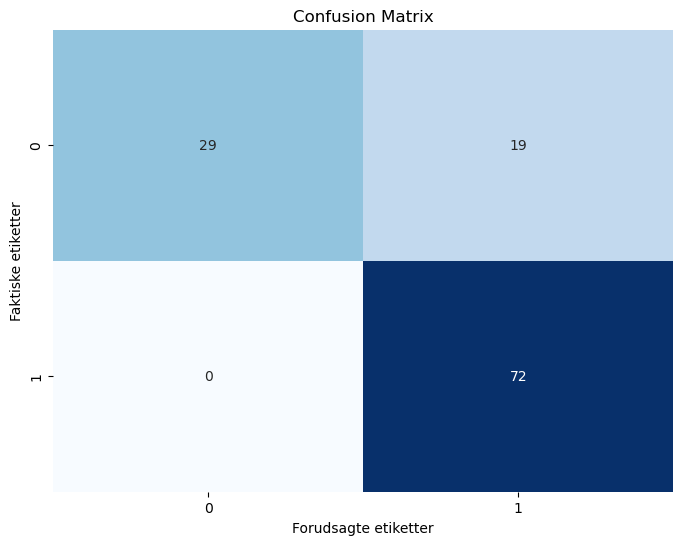

In [16]:
# Udskriv de forudsagte værdier
print("Forudsagte værdier:", y_pred)

# Evaluer modellen
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Klassifikationsrapport
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Visualisering af Confusion Matrix som heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Forudsagte etiketter")
plt.ylabel("Faktiske etiketter")
plt.show()

## RandomForestRegressor for price predictions

If we would predict a price, we will go for the RandomForestRegressor as it effectively handles complex relationships and interactions between features, provides robust predictions even with noisy data, and demonstrates excellent performance in terms of accuracy and interpretability, especially when evaluating the importance of different predictors.

In [17]:
df

,Date,Open SP500,High SP500,Low SP500,Close SP500,Volume SP500,Interest Rate,Unemployment Rate,Inflation Rate,CPIAUCSL,Open RUSSELL2000,High RUSSELL2000,Low RUSSELL2000,Close RUSSELL2000,Volume RUSSELL2000,Close Oil,Close Gold,Open Gold,High Gold,Low Gold,Change % Gold,OPEN_CLOSE_CHANGE_ABB_SP500,OPEN_CLOSE_CHANGE_ABB_RUSSELL2000,OPEN_CLOSE_CHANGE_ABB_Gold,Interest_Rate_Change,Inflation_Rate_Change,Unemployment_Rate_Change,CPI_Change,OPEN_CLOSE_CHANGE_ABB_SP500_Flagged,OPEN_CLOSE_CHANGE_ABB_RUSSELL2000_Flagged,Flag_Next_Month_SP500,Flag_Next_Month_RUSSELL2000
0,1987-11-30,244.770004,257.209991,225.750000,230.300003,3.892930e+09,6.69,5.8,4.4,115.400,110.790001,122.050003,107.900002,111.699997,3.892920e+09,17.70,490.46,469.10,490.46,457.14,1.23,-14.419954,0.929994,-51.78,-0.60,0.1,-0.2,0.400,0,1,1.0,1.0
1,1987-12-31,230.320007,253.350006,221.240005,247.080002,3.926750e+09,6.77,5.7,4.2,115.600,111.690002,121.589996,106.160004,120.419998,3.926750e+09,17.60,485.85,492.67,498.25,479.47,0.70,16.649993,8.750015,-70.46,0.08,-0.2,-0.1,0.200,1,1,1.0,1.0
2,1988-01-31,247.839996,261.779999,240.169998,257.070007,3.664840e+09,6.83,5.7,4.3,116.000,119.500000,128.190002,118.610001,125.239998,3.664840e+09,16.28,454.01,487.45,487.06,454.01,-2.69,9.150053,5.750007,-72.26,0.06,0.1,0.0,0.400,1,1,1.0,1.0
3,1988-02-29,257.049988,267.820007,247.820007,267.820007,3.693240e+09,6.58,5.7,4.3,116.200,125.239998,137.690002,124.940002,136.100006,3.693240e+09,14.73,430.23,455.80,454.63,429.45,0.18,11.189988,10.829993,-70.33,-0.25,0.0,0.0,0.200,1,1,0.0,1.0
4,1988-03-31,267.820007,272.640015,256.070007,258.890015,4.052970e+09,6.58,5.7,4.4,116.500,136.100006,143.380005,136.070007,142.149994,4.052970e+09,15.65,453.85,431.55,456.74,427.66,-0.63,-8.829986,6.000001,-48.16,0.00,0.1,0.0,0.300,0,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,2017-07-31,2431.389893,2484.040039,2407.699951,2470.300049,6.316940e+10,1.07,4.7,2.2,244.163,1416.469971,1452.089966,1398.829956,1425.140015,6.300930e+10,51.99,1269.55,1241.46,1271.48,1204.85,0.02,21.260254,7.000248,24.29,0.01,0.0,0.0,0.000,1,1,0.0,0.0
357,2017-08-31,2477.100098,2490.870117,2417.350098,2471.649902,7.061603e+10,1.07,4.7,2.2,245.183,1426.030029,1430.660034,1349.349976,1405.280029,7.061603e+10,52.69,1322.07,1268.80,1326.14,1251.41,1.02,-12.118655,-19.870245,44.48,0.00,0.0,0.0,1.020,0,0,1.0,1.0
358,2017-09-30,2474.419922,2519.439941,2446.550049,2519.360107,6.633798e+10,1.06,4.7,2.2,246.435,1405.819946,1493.560059,1393.880005,1490.859985,6.633798e+10,57.02,1279.45,1321.80,1357.94,1277.64,-0.61,30.170895,83.840209,-43.04,-0.01,0.0,0.0,1.252,1,1,1.0,1.0
359,2017-10-31,2521.199951,2582.979980,2520.399902,2575.260010,7.087157e+10,1.07,4.7,2.2,246.435,1491.050049,1514.939941,1482.530029,1502.530029,7.087157e+10,61.35,1271.58,1279.50,1306.80,1260.89,-0.37,26.179931,8.090335,-6.61,0.01,0.0,0.0,0.000,1,1,1.0,1.0


In [18]:
columns_to_drop_sp500_fr = ['Date',
       #'Open SP500', 'High SP500', 'Low SP500',
       'Close SP500',
       'Volume SP500', 'Unemployment Rate',
       #'Interest Rate', 'Inflation Rate', 'CPIAUCSL',
       'Open RUSSELL2000', 'High RUSSELL2000', 'Low RUSSELL2000', 'Close RUSSELL2000', 'Volume RUSSELL2000',
       #'Close Oil', 'Close Gold',
       'Open Gold',
       'High Gold', 'Low Gold', 'Change % Gold',
       'OPEN_CLOSE_CHANGE_ABB_SP500',
       'OPEN_CLOSE_CHANGE_ABB_RUSSELL2000', 'OPEN_CLOSE_CHANGE_ABB_Gold',
       'Interest_Rate_Change', 'Inflation_Rate_Change', 'CPI_Change',
       'Unemployment_Rate_Change',
       'OPEN_CLOSE_CHANGE_ABB_SP500_Flagged', 'OPEN_CLOSE_CHANGE_ABB_RUSSELL2000_Flagged',
       'Flag_Next_Month_SP500',
       'Flag_Next_Month_RUSSELL2000'
    ]

columns_to_drop_russell2000_fr = ['Date',
       'Open SP500', 'High SP500', 'Low SP500', 'Close SP500', #'Volume SP500',
       'Interest Rate', 'Unemployment Rate', 'Inflation Rate', 'CPIAUCSL',
       'Open RUSSELL2000', 'High RUSSELL2000', 'Low RUSSELL2000', 'Close RUSSELL2000', #'Volume RUSSELL2000',
       'Close Oil', 'Close Gold', 'Open Gold', 'High Gold', 'Low Gold', 'Change % Gold',
       'OPEN_CLOSE_CHANGE_ABB_SP500', 'OPEN_CLOSE_CHANGE_ABB_RUSSELL2000', 'OPEN_CLOSE_CHANGE_ABB_Gold',
       #'Interest_Rate_Change', 'Inflation_Rate_Change', 'Unemployment_Rate_Change', 'CPI_Change',
       'OPEN_CLOSE_CHANGE_ABB_SP500_Flagged', 'OPEN_CLOSE_CHANGE_ABB_RUSSELL2000_Flagged',
       'Flag_Next_Month_SP500',
       #'Flag_Next_Month_RUSSELL2000'
    ]

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 2. Definér X og y
X = df.drop(columns=columns_to_drop_sp500_fr)  # Alle kolonner bortset fra Close SP500
y = df['Close SP500']

# 3. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Træn model
model_rfr = RandomForestRegressor(n_estimators=100, random_state=42)
model_rfr.fit(X_train, y_train)

# 5. Forudsig
y_pred = model_rfr.predict(X_test)

# 6. Evaluering
print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))
print('R²:', r2_score(y_test, y_pred))

RMSE: 31.930563444297785
R²: 0.9971161933264072


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [20]:
# 3. Split data (valgfrit, hvis du ønsker at bruge det til test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Træn model
model_rfr = RandomForestRegressor(n_estimators=100, random_state=42)

# Krydsvalidering
cv_scores = cross_val_score(model_rfr, X_train, y_train, cv=15, scoring='neg_mean_squared_error')
cv_rmse = (-cv_scores)**0.5  # RMSE
print('Krydsvalidering RMSE:', cv_rmse)
print('Gennemsnitlig RMSE fra krydsvalidering:', cv_rmse.mean())

# Træn modellen med hele træningsdatasættet
model_rfr.fit(X_train, y_train)

# 5. Forudsig
y_pred = model_rfr.predict(X_test)

# 6. Evaluering
print('Test RMSE:', mean_squared_error(y_test, y_pred, squared=False))
print('Test R²:', r2_score(y_test, y_pred))

Krydsvalidering RMSE: [27.84108214 30.54348031 28.20276097 32.90124124 23.99182965 42.31481558
 27.47172091 27.52561735 42.52241508 25.62675213 31.65058173 27.35168912
 22.43211909 26.99404628 45.8042939 ]
Gennemsnitlig RMSE fra krydsvalidering: 30.87829636441887
Test RMSE: 31.930563444297785
Test R²: 0.9971161933264072


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
